In [48]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import transform

from shapely.geometry import Point, Polygon
import datetime

from io import StringIO
from pathlib import Path, PureWindowsPath
import os
import sys
from functools import partial

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from clean_tweets import geometrize_tweets
data_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets/")

Wall time: 0 ns


In [49]:
data_path

WindowsPath('C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets')

In [18]:
def convert_shapefile_crs(shapefile):
    """
    Convert shapefile CRS to WGS84 (epsg:4326).
    Function may take a while to run.
    Source: https://gis.stackexchange.com/a/127432

    Parameters
    ----------
    shapefile : geopandas.GeoDataFrame

    Returns
    -------
    shapefile : geopandas.GeoDataFrame
        Contains updated 'geometry' column
    """
    in_proj = pyproj.Proj(shapefile.crs)
    out_proj = pyproj.Proj(init='epsg:4326')

    project = partial(
        pyproj.transform,
        in_proj,
        out_proj
    )
    shapefile['geometry'] = [transform(project, geom) for geom in shapefile['geometry']]

    return shapefile

In [19]:
def find_frequencies(series, pat, case=False, ratio=False):
    """
    Find the number (or ratio) of times that a pattern occurs in a list of tweets.

    Parameters
    ----------
    series : pd.Series
        Column of text containing tweets. Must be dtype

    pat : string
        Regular expression to check against `series`.

    case : boolean (optional, default=False)
        If True, comparisons are case-sensitive (e.g. 'pattern' != 'PaTtErN')
        If False, comparisons are case-insensitive. (e.g. 'pattern' == 'PaTtErN')

    ratio : boolean (optional, default=False)
        If True, return the ratio (number_of_matches) / (number_of_tweets).
        If False, return a tuple (number_of_matches, number_of_tweets).

    Returns
    -------
    integer or float

    """
    n = len(series)
    num_matches = series.str.contains(pat, case=case).sum()

    if ratio:
        return num_matches / n
    else:
        return num_matches, n

In [21]:
def assign_home_location(data, uid='u_id', SA2='SA2_5DIG16', date='date', hour='hour',
                         min_tweets=10, min_days=10, min_hours=8):
    """
    Assign a home location for Twitter users and their tweets based on following methodology:

    1. Consider tracts satisfying the following properties:
        - More than `min_tweets` tweets total
        - Sent from more than `min_days` different days
        - Sent from more than `min_hours` different hours of the day
    2. Of the remaining candidates, select the tract with the most tweets

    This function does not guarantee that all Twitter users/tweets will be assigned a home location.
    Some users will not have any tweets that meet the criteria defined above; this will result in a
    missing value (np.NaN) being assigned to the home tract for that user's tweets.


    Parameters
    ----------
    data : pd.DataFrame or gpd.geodataframe.GeoDataFrame
        DataFrame containing the following columns (variables passed into the function):
            - uid : Twitter user ID
            - sa2 : Tract identifier (e.g. tract ID, FIPS code)
            - date : Datetime object containing just the date
                     (year, month, and day; not a full timestamp)
            - hour : Integer containing 24-hour-format hour of tweet

    uid, tract, date, hour : string (optional, default='u_id', 'OBJECTID', 'date', 'hour')
        Column names to extract from `data`; additional details under `data` parameter

    min_tweets : integer (optional, default=10)
        Minimum number of tweets required from a user at a valid tract

    min_days : integer (optional, default=10)
        Minimum number of unique days a user must tweet from a valid tract

    min_hours : integer (optional, default=8)
        Minimum number of unique hours a user must tweet from a valid tract


    Returns
    -------
    pd.Series of length data.shape[0], containing a home location for each tweet.
    Note that this function is not an inplace operation.
    e.g. df['home_tract'] = assign_home_location(df)

    """
    # Note: groupby is done multiple times to save computation time
    home_locations = (
        data
        # More than min_tweets
        .groupby(['u_id', 'SA2_5DIG16']) #will need to edit this to a different code later
        .filter(lambda user_tract: len(user_tract) > min_tweets)

        # More than min_days
        .groupby(['u_id', 'SA2_5DIG16'])  #will need to edit this to a different code later
        .filter(lambda user_tract: user_tract[date].nunique() > min_days)

        # More than min_hours
        .groupby(['u_id', 'SA2_5DIG16'])  #will need to edit this to a different code later
        .filter(lambda user_tract: user_tract[hour].nunique() > min_hours)

        # Extract home location
        .groupby(['u_id', 'SA2_5DIG16'])  #will need to edit this to a different code later
        .size()
        .reset_index(name='count')
        .sort_values(by='count', ascending=False)
        .loc[:, ['u_id', 'SA2_5DIG16']]
        .groupby('u_id')
        .first()
        .loc[:, 'SA2_5DIG16']
    )

    return data[uid].map(home_locations.to_dict())


In [22]:
def summary_stats(data):
    """
    Analyze the following:
        - Number of tweets (printed output)
        - Number of unique users (printed output)
        - Median number of tweets/user (returned output)
        - Number of tweets/user at the 99th percentile (returned output)

    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id

    Returns
    -------
    median_tweets : int or float
        Median number of tweets/user

    pct_99_tweets : int or float
        99th percentile of tweets/user
    """
    # Number of tweets
    print("{} total tweets".format(len(data)))

    # Number of unique users
    print("{} unique users\n".format(data['u_id'].nunique()))

    # Percentiles of tweets/user (median + 99th)
    pct_50_tweets, pct_99_tweets = data.groupby('u_id').size().quantile([.50, .99])
    print("Median number of tweets/user: {} tweets".format(pct_50_tweets))
    print("99th percentile of tweets/user: {} tweets".format(pct_99_tweets))

    return pct_50_tweets, pct_99_tweets


In [54]:
def filter_and_home_assign(data, shapefile, lower, upper):
    """
    Find subset of data to analyze based on lower/upper bounds on tweets/user, 
    then add home locations.
    
    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id
    
    shapefile : gpd.GeoDataFrame
        Shapefile for tracts in tweets location.
        Must be in WGS84 (epsg:4326) format (to align with tweet lat/lon).
    
    lower, upper : int or float
        Lower (inclusive) and upper (exclusive) bounds on tweets/user.
        
    Returns
    -------
    filtered : gpd.GeoDataFrame
        Collection of tweets filtered by lower/upper and with tweet geographies.
        Contains new columns:
            - 'timestamp' : pd.Timestamp for time of tweet published
            - 'date' : date (int) of tweet published
            - 'hour' : 24-hour (int) of tweet published
            - 'home' : name of home location codigo (some may be NaN)
            - 'is_home' : boolean indicating whether tweet was made at home
    """
    # Filter based on lower and upper bound on tweets/user
    filtered = data.groupby('u_id').filter(lambda group: (len(group) >= lower) & (len(group) < upper))
    
    # Geometrize tweets (inplace) based on lat/lon
    filtered = geometrize_tweets(filtered)
    
    # Spatial join with tracts
    filtered = gpd.sjoin(filtered, shapefile, how='left', op='intersects')
    
    # Add datetime
    filtered['timestamp'] = pd.to_datetime(filtered['created_at'] // 1000, unit='s')
    filtered['date'] = filtered['timestamp'].dt.date
    filtered['hour'] = filtered['timestamp'].dt.hour
    
    # Add home location
    filtered['home'] = assign_home_location(filtered, SA2='SA2_MAIN16')
    filtered['is_home'] = filtered['SA2_MAIN16'] == filtered['home']
    
    return filtered

In [50]:
tweets_2012 = pd.read_csv(data_path/'AUST_TWT_2012.csv')

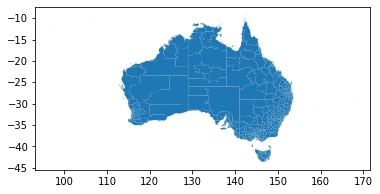

In [58]:
au_shape_sa2 = gpd.read_file('C:\\Users\\emman\\box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\SA2 Shapefiles\\SA2_2016_AUST.dbf')
# Crikey, our area is too big
au_shape_sa2.plot()
# We also need to change the crs 
au_shape_sa2.crs = {'init': 'epsg:4326'}
# have the shapefile only have areas that are in the state of New South Wales, and furthermore, in Greater Sydney
au_shape_sa2 = au_shape_sa2[au_shape_sa2.STE_NAME16 == 'New South Wales']
au_shape_sa2 = au_shape_sa2[au_shape_sa2.GCC_NAME16 == 'Greater Sydney']

In [51]:
tweets_2012.head()

,Unnamed: 0,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,timestamp,date
0,0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),2012-07-23 14:31:39,2012-07-23 00:00:00
1,1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872),2012-07-23 13:29:28,2012-07-23 00:00:00
2,2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),2012-07-23 13:31:39,2012-07-23 00:00:00
3,3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),2012-07-23 13:38:57,2012-07-23 00:00:00
4,4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),2012-07-23 13:41:42,2012-07-23 00:00:00


In [52]:
pct_50, pct_99 = summary_stats(tweets_2012)

695571 total tweets
24391 unique users

Median number of tweets/user: 4.0 tweets
99th percentile of tweets/user: 393.1999999999971 tweets


In [59]:
twt2012 = filter_and_home_assign(tweets_2012, au_shape_sa2, pct_50, pct_99)

NameError: name 'crs' is not defined